In [8]:
#import necessary libraries and Modules
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import hexagon_app 

import importlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import math
from PIL import Image, ImageDraw, ImageTk
import tkinter as tk



In [9]:
importlib.reload(IMF)
importlib.reload(PF)
importlib.reload(IA)

<module 'ImageAnalysis' from 'c:\\Users\\HP\\Documents\\JHU_Academics\\Research\\PHANGS\\PHANGSDustFill\\ImageAnalysis.py'>

Thresholded image saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png
(1038, 1042)


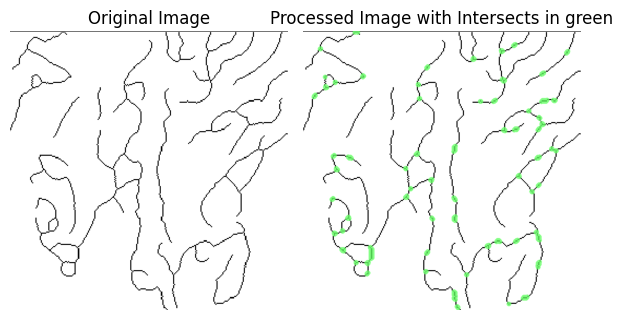

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png
(1038, 1042)


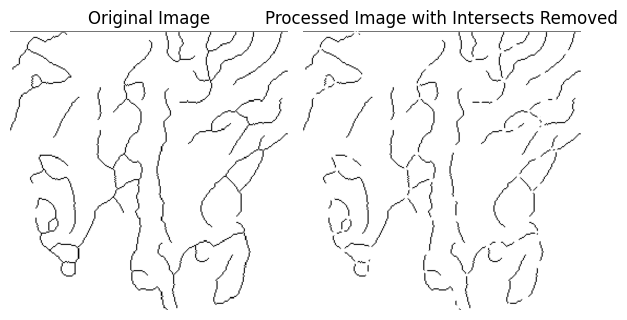

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png


In [10]:
input_image = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1.png'
invert_input = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png'
intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png'

IMF.invert_image(input_image, invert_input)
IA.identify_intersects(invert_input, intersects_removed,dot_size=8,box_size=10, perc = .4, RGBA_color = (100, 255, 100, 200), title = 'Processed Image with Intersects in green')
IA.identify_intersects(invert_input, intersects_removed,dot_size=4,box_size=10, perc = .4, RGBA_color = (255, 255, 255, 255), title = 'Processed Image with Intersects Removed')

Thresholded image saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\InvertIntersects.png


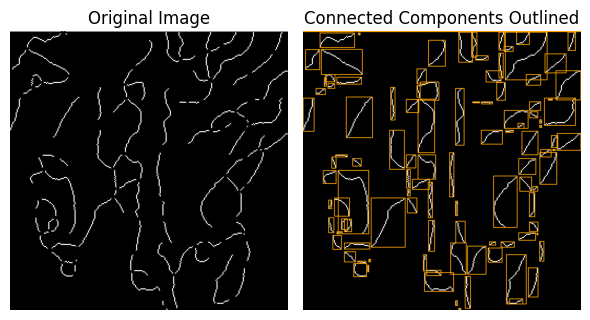

In [11]:
invert_intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\InvertIntersects.png'
IMF.invert_image(intersects_removed ,invert_intersects_removed)
labels, stats = IA.identify_connected_components(invert_intersects_removed)

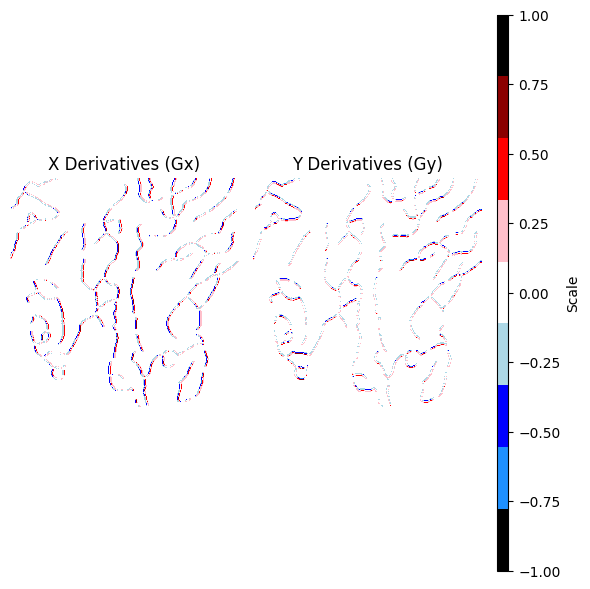

In [12]:
# read the image
img = cv2.imread(intersects_removed)

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# blur
blur = cv2.GaussianBlur(gray, (0,0), 1.3, 1.3)
# apply sobel derivatives
sobelx = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=3)
PF.plot_sobel_derivatives(sobelx, sobely)

c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:91: RuntimeWarning: divide by zero encountered in divide
  angle_map = -1*np.degrees(np.arctan(Gy/Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:91: RuntimeWarning: invalid value encountered in divide
  angle_map = -1*np.degrees(np.arctan(Gy/Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:77: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arctan(sin_sum/cos_sum))


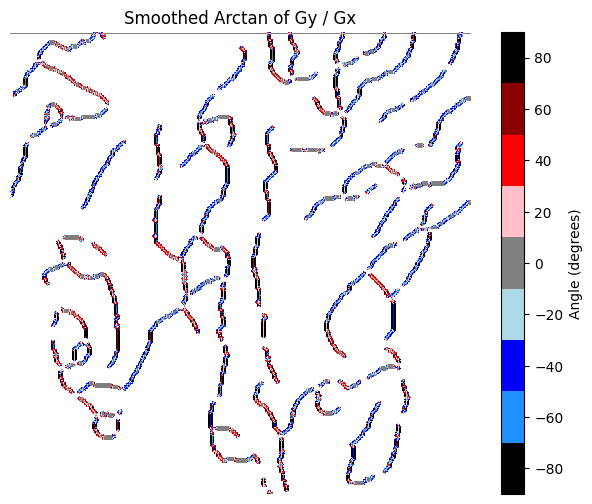

Smoothed angle map saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png


In [13]:
smoothed_angles = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'

smoothed_angle_map, copy_angled_map = PF.plot_arctan_with_smoothing(sobely, sobelx,invert_intersects_removed, 1, smoothed_angles)

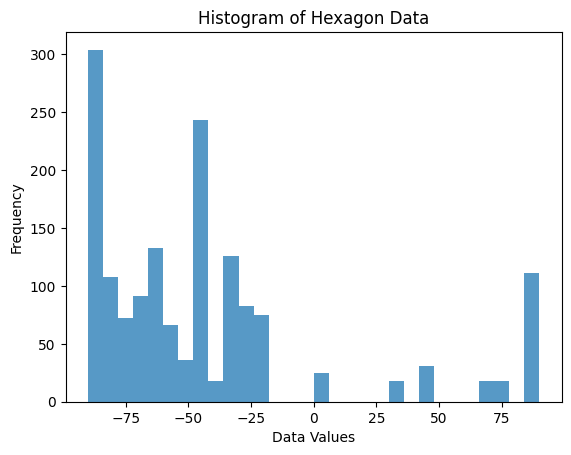

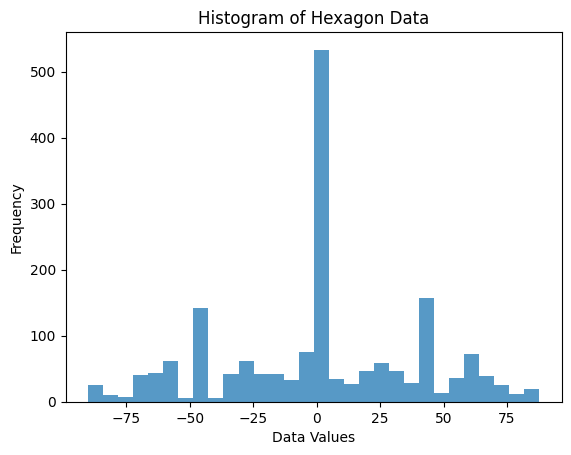

In [37]:
import math
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import cv2
import tkinter as tk
from tkinter import ttk
from matplotlib import pyplot as plt

# Sample data array with dimensions 1042x1038
data_array = smoothed_angle_map

# Helper functions
def hexagon_corners(center, size):
    x, y = center
    w = math.sqrt(3) * size
    h = 2 * size

    return [
        (x - w / 2, y - h / 4),
        (x, y - h / 2),
        (x + w / 2, y - h / 4),
        (x + w / 2, y + h / 4),
        (x, y + h / 2),
        (x - w / 2, y + h / 4)
    ]

def hexagonify_with_outline(image, hexagon_size):
    im_copy = image.copy()
    draw = ImageDraw.Draw(im_copy)

    w = math.sqrt(3) * hexagon_size
    h = 2 * hexagon_size

    num_hor = int(im_copy.size[0] / w) + 2
    num_ver = int(im_copy.size[1] / h * 4 / 3) + 2

    hexagons = []

    for i in range(num_hor * num_ver):
        column = i % num_hor
        row = i // num_hor
        even = row % 2

        center = (column * w + even * w / 2, row * h * 3 / 4)
        p = hexagon_corners(center, hexagon_size)
        p_clipped = [(int(np.clip(point[0], 0, im_copy.size[0] - 1)), int(np.clip(point[1], 0, im_copy.size[1] - 1))) for point in p]

        draw.polygon(p_clipped, outline="purple")
        hexagons.append((center, p_clipped))

    return im_copy, hexagons

def point_in_polygon(point, polygon):
    num_vertices = len(polygon)
    x, y = point
    inside = False

    p1x, p1y = polygon[0]
    for i in range(num_vertices + 1):
        p2x, p2y = polygon[i % num_vertices]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        x_intersection = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= x_intersection:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside

def update_image(hexagon_size, original_image):
    modified_image, hexagons = hexagonify_with_outline(original_image, hexagon_size)
    im_display = np.array(modified_image)
    #im_display = cv2.cvtColor(im_display, cv2.COLOR_RGBA2BGRA)  # Ensure BGRA format for overlay
    height, width = im_display.shape[:2]
    scale = min(800 / width, 800 / height)
    im_display_resized = cv2.resize(im_display, (int(width * scale), int(height * scale)))
    cv2.imshow('image', im_display_resized)
    return hexagons, im_display

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        hexagons, im_display, data_array = param['hexagons'], param['im_display'], param['data_array']
        height, width = im_display.shape[:2]
        scale = min(800 / width, 800 / height)
        x = int(x / scale)
        y = int(y / scale)
        param['hex_data'].clear()

        # Reset image to original before highlighting the new hexagon
        im_display = param['im_display_base'].copy()
        for center, hexagon in hexagons:
            if point_in_polygon((x, y), hexagon):
                mask = Image.new("RGBA", (im_display.shape[1], im_display.shape[0]), (0, 0, 0, 0))
                mask_draw = ImageDraw.Draw(mask)
                mask_draw.polygon(hexagon, fill=(128, 0, 128, 128))
                im_overlay = Image.alpha_composite(Image.fromarray(im_display), mask)
                im_display = np.array(im_overlay)
                im_display = cv2.cvtColor(im_display, cv2.COLOR_RGBA2BGRA)  # Ensure BGRA format after overlay
                height, width = im_display.shape[:2]
                scale = min(800 / width, 800 / height)
                im_display_resized = cv2.resize(im_display, (int(width * scale), int(height * scale)))
                cv2.imshow('image', im_display_resized)

                # Append corresponding data to hex_data
                min_x = int(min([px for px, _ in hexagon]))
                max_x = int(max([px for px, _ in hexagon]))
                min_y = int(min([py for _, py in hexagon]))
                max_y = int(max([py for _, py in hexagon]))

                for px in range(min_x, max_x + 1):
                    for py in range(min_y, max_y + 1):
                        if point_in_polygon((px, py), hexagon):
                            if 0 <= py < 1042 and 0 <= px < 1038:
                                param['hex_data'].append(data_array[py][px])

                param['im_display'] = im_display
                break

def analyze_hexagon(hex_data):
    plt.hist(hex_data, bins=30, alpha=0.75)
    plt.title('Histogram of Hexagon Data')
    plt.xlabel('Data Values')
    plt.ylabel('Frequency')
    plt.show()

def increase_hexagon_size(param):
    param['hexagon_size'] += 1
    param['hexagons'], param['im_display_base'] = update_image(param['hexagon_size'], param['original_image'])

def decrease_hexagon_size(param):
    param['hexagon_size'] = max(1, param['hexagon_size'] - 1)
    param['hexagons'], param['im_display_base'] = update_image(param['hexagon_size'], param['original_image'])

# Main code
if __name__ == "__main__":
    original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'  # Replace with your image path
    hexagon_size = 60

    original_image = Image.open(original_image_path).convert("RGBA")

    hexagons, im_display = update_image(hexagon_size, original_image)

    param = {
        'hexagon_size': hexagon_size,
        'original_image': original_image,
        'hexagons': hexagons,
        'im_display': im_display,
        'im_display_base': im_display.copy(),
        'data_array': data_array,
        'hex_data': []
    }

    # Create window and set mouse callback
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', click_event, param)

    # Create Tkinter window for buttons
    root = tk.Tk()
    root.title("Hexagon Size Adjuster")

    increase_button = ttk.Button(root, text="+", command=lambda: increase_hexagon_size(param))
    increase_button.pack(side=tk.LEFT)

    decrease_button = ttk.Button(root, text="-", command=lambda: decrease_hexagon_size(param))
    decrease_button.pack(side=tk.LEFT)

    analyze_button = ttk.Button(root, text="Analyze Hexagon", command=lambda: analyze_hexagon(param['hex_data']))
    analyze_button.pack(side=tk.LEFT)

    def on_closing():
        cv2.destroyAllWindows()
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_closing)
    root.mainloop()


In [16]:
img = cv2.imread(smoothed_angles)
print(np.shape(img))

data = copy_angled_map
num_col = len(data[0])
num_pixels = np.size(data)
print(num_pixels//num_col)
print(np.shape(data))


(1042, 1038, 3)
1042
(1042, 1038)
